# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
from utils.plotting_utils import draw_attention
from transformers import AutoTokenizer
import os

c:\Users\wsr20\anaconda3\envs\CoT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [2]:
DATA_INDEX = 4
DATA_FOLDER = f'./experimental_data/gemma-2-2b-it/custom_experiment_{DATA_INDEX}/'
FIG_FOLDER = f"./figs/gemma-2-2b-it/custom_experiment_{DATA_INDEX}/"
if not os.path.exists(FIG_FOLDER):
    os.makedirs(FIG_FOLDER, exist_ok=True)
COT = " Let's think step by step:"
REG_PROMPT = "True or false: Following the \"stay-at-home\" order, the CEO is likely to wear slippers more often than any other shoes even when at work."
COT_PROMPT = REG_PROMPT + COT
RELEVENT_QUESTION = "\n **Are days shorter in summer?**"
IRRELEVENT_QUESTION = ".\n **How old is Anthony?**"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("./models/google/gemma-2-2b-it")

In [ ]:
relevant = tokenizer(COT_PROMPT + RELEVENT_QUESTION)['input_ids']
relevent = [tokenizer.decode(id) for id in relevant]
irrelevant = tokenizer(COT_PROMPT + IRRELEVENT_QUESTION)['input_ids']
irrelevant = [tokenizer.decode(id) for id in irrelevant]
qkv_cot = tokenizer(COT_PROMPT)['input_ids']
qkv_cot = [tokenizer.decode(id) for id in qkv_cot]
qkv_reg = tokenizer(REG_PROMPT)['input_ids']
qkv_reg = [tokenizer.decode(id) for id in qkv_reg]
desc = qkv_reg[1:]
desc_cot = qkv_cot[1:]
cot_len = len(tokenizer(COT)['input_ids']) - 1  # -1 to remove the bos token

In [4]:
print(f"Relevant question length: {len(relevant)}")
print(f"Irrelevant question length: {len(irrelevant)}")
print(f"QKV COT length: {len(qkv_cot)}")
print(f"QKV REG length: {len(qkv_reg)}")

Relevant question length: 51
Irrelevant question length: 50
QKV COT length: 42
QKV REG length: 34


# Load Data

In [5]:
acts_q_cot = torch.load(f'{DATA_FOLDER}cot/acts_q.pt', map_location=device)
acts_v_cot = torch.load(f'{DATA_FOLDER}cot/acts_v.pt', map_location=device)
acts_k_cot = torch.load(f'{DATA_FOLDER}cot/acts_k.pt', map_location=device)
acts_q_reg = torch.load(f'{DATA_FOLDER}regular/acts_q.pt', map_location=device)
acts_k_reg = torch.load(f'{DATA_FOLDER}regular/acts_k.pt', map_location=device)
acts_v_reg = torch.load(f'{DATA_FOLDER}regular/acts_v.pt', map_location=device)
acts_attn_scores_cot = torch.load(f'{DATA_FOLDER}cot/acts_attn_scores.pt', map_location=device)
acts_attn_scores_reg = torch.load(f'{DATA_FOLDER}regular/acts_attn_scores.pt', map_location=device)
# acts_res_irrelevant = torch.load(f'{DATA_FOLDER}acts_res_irrelevant.pt', map_location=device)
# acts_res_relevant = torch.load(f'{DATA_FOLDER}acts_res_relevant.pt', map_location=device)

C:\Users\wsr20\AppData\Local\Temp\ipykernel_21708\4084110748.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts_q_cot = torch.load(f'{DATA_FOLDER}cot/acts_q.pt', map_l

In [6]:
acts_attn_scores_cot = acts_attn_scores_cot[:, 0, :, :, :]
acts_attn_scores_reg = acts_attn_scores_reg[:, 0, :, :, :]

In [7]:
print(acts_q_cot.shape)
print(acts_k_cot.shape)
print(acts_q_reg.shape)
print(acts_attn_scores_cot.shape)
# print(acts_res_relevant.shape)
print(cot_len)

torch.Size([26, 41, 8, 256])
torch.Size([26, 41, 4, 256])
torch.Size([26, 34, 8, 256])
torch.Size([26, 8, 41, 41])
9


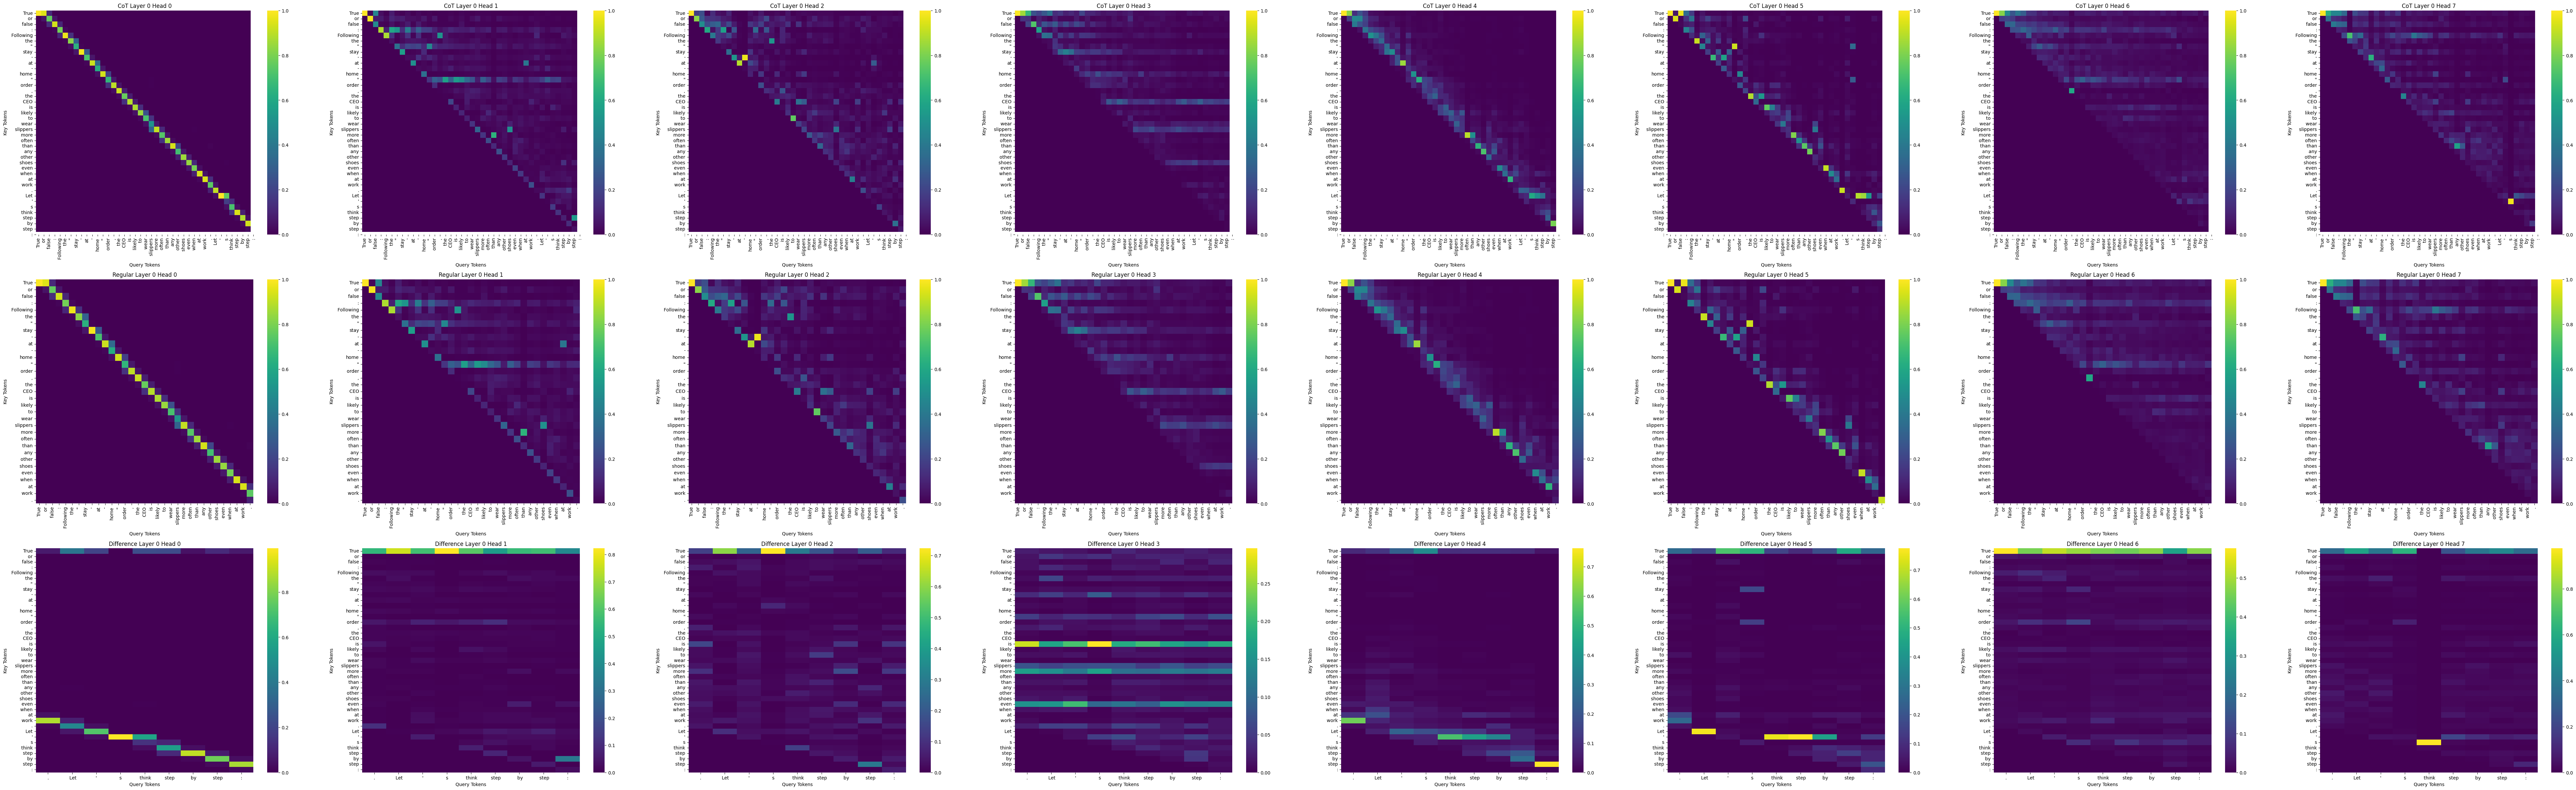

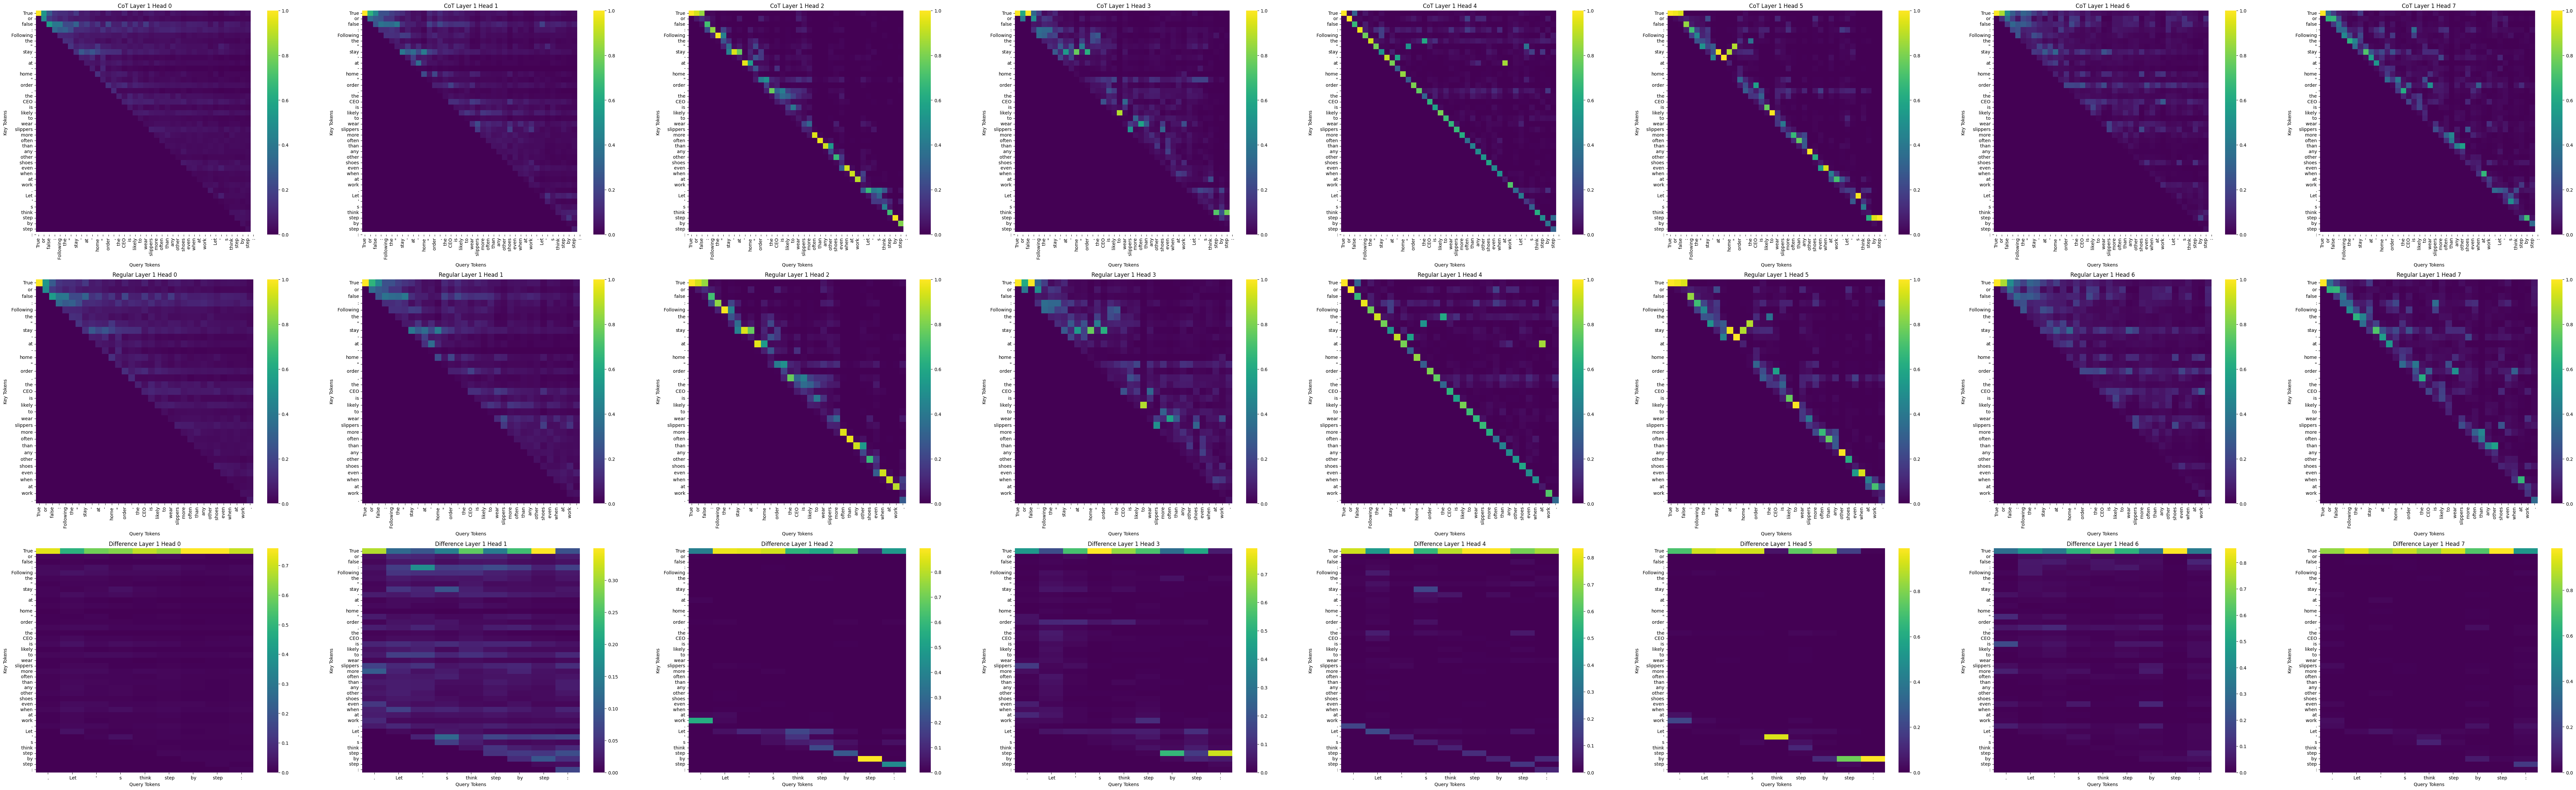

KeyboardInterrupt: 

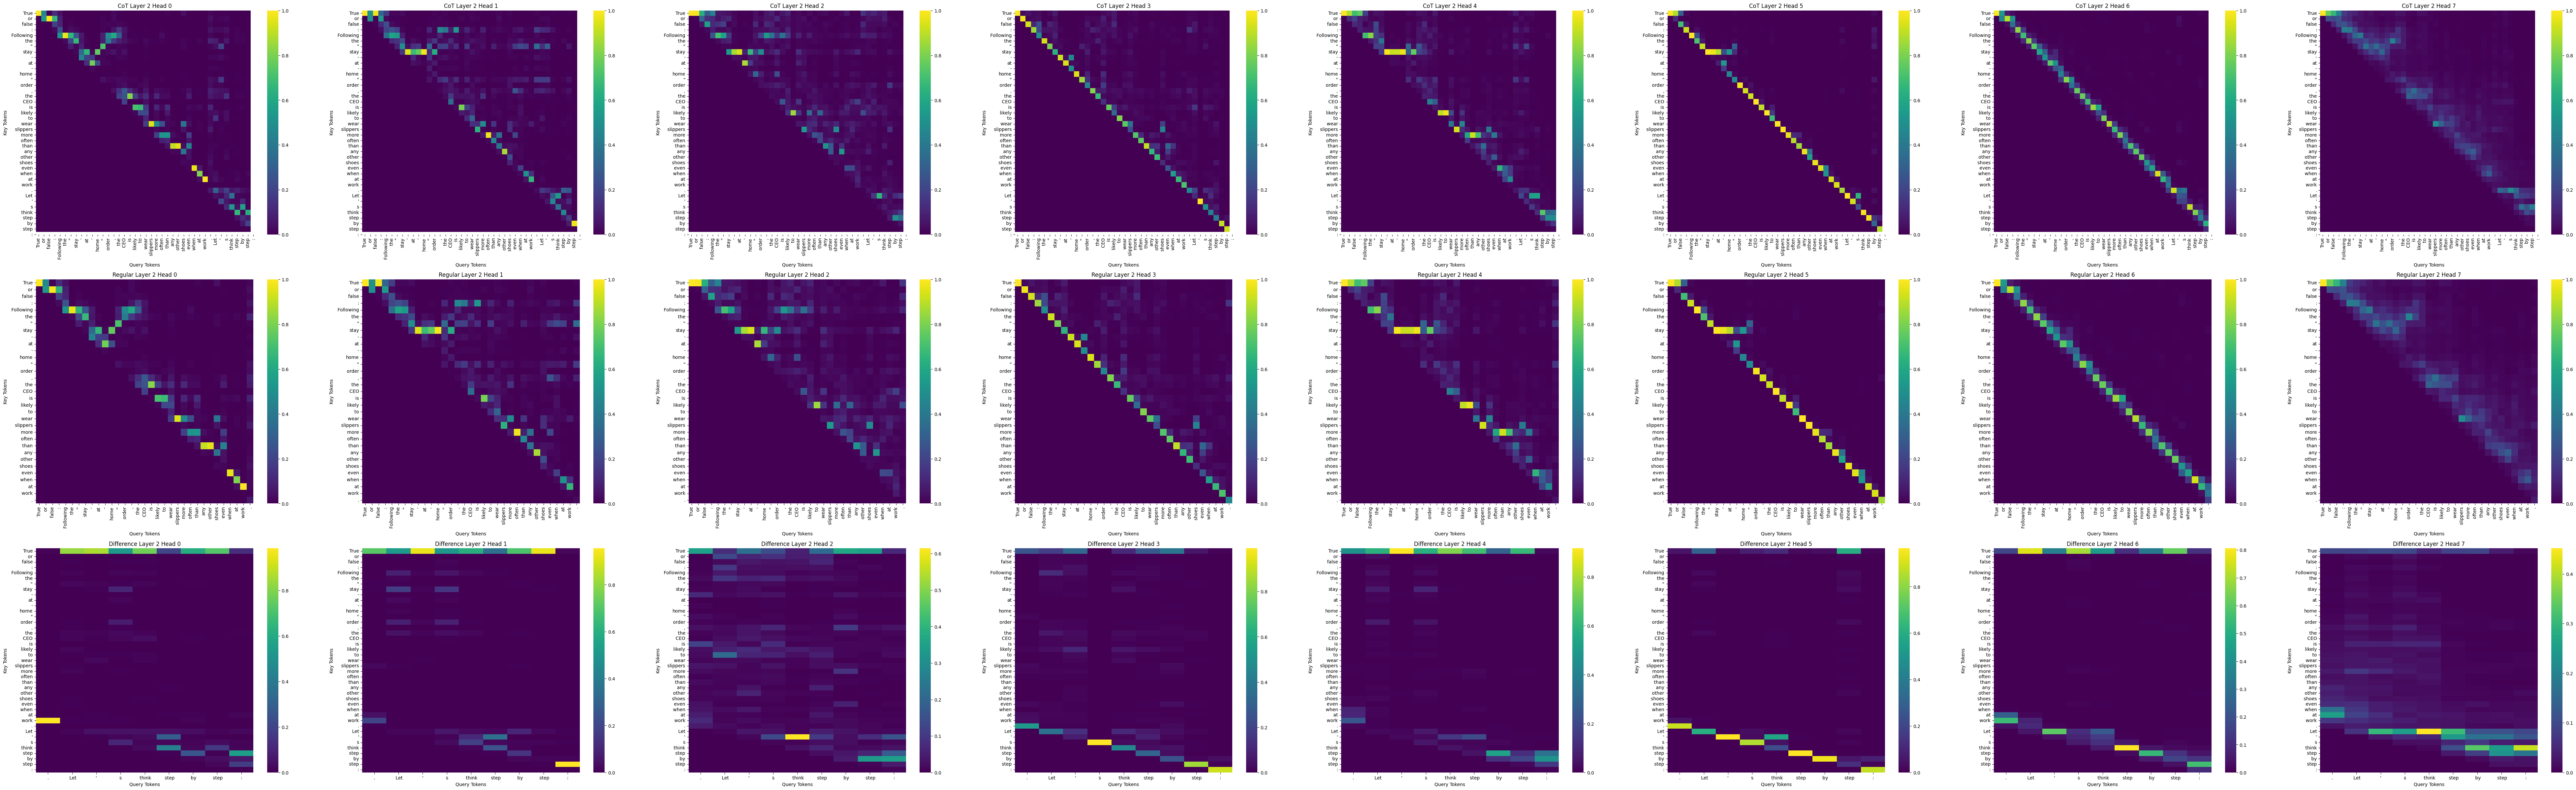

In [11]:
layers = acts_attn_scores_cot.shape[0]

for i in range(layers):
    fig, axes = plt.subplots(nrows=3, ncols=acts_attn_scores_cot.shape[1], figsize=(100, 30))
    for j in range(acts_attn_scores_cot.shape[1]):
        acts_cot = acts_attn_scores_cot[i, j, 1:, 1:]
        draw_attention(torch.softmax(acts_cot, dim=-1), f"CoT Layer {i} Head {j}", axis=axes[0, j], tokens_q=desc_cot, tokens_k=desc_cot)
        
    for j in range(acts_attn_scores_reg.shape[1]):
        acts_reg = acts_attn_scores_reg[i, j, 1:, 1:]
        draw_attention(torch.softmax(acts_reg, dim=-1), f"Regular Layer {i} Head {j}", axis=axes[1, j], tokens_q=desc, tokens_k=desc)
        
    for j in range(acts_attn_scores_reg.shape[1]):
        cot = torch.softmax(acts_attn_scores_cot[i, j, -cot_len:, :], -1)
        draw_attention(cot, f"Difference Layer {i} Head {j}", axis=axes[2, j], tokens_q=qkv_cot[-cot_len:], tokens_k=desc_cot)
    plt.savefig(f'{FIG_FOLDER}attn_layer_{i}.png')
    plt.show()